# Desempenho de algoritmos de classificação na detecção de intrusão em redes de dispositivos IoT

## Importações

In [57]:
import glob
import time
from collections import OrderedDict
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Variáveis globais

In [58]:
DATASET_DIRECTORY = "./CICIoT2023/"
GENERATE_DATASETS = False
EIGHT_CLASSES = True
RESULTS_FILE = "./results.csv"
FEATURE_SELECTION = False

## DTOs

In [59]:
@dataclass
class ModelDataset:
    x_train: np.ndarray
    y_train: np.ndarray
    x_test: pl.DataFrame
    y_test: np.ndarray

In [60]:
@dataclass
class Results:
    model: str
    accuracy_score: float
    precision_score: float
    recall_score: float
    f1_score: float
    train_num_rows: int
    test_num_rows: int
    num_features: int
    duration_training: float
    feature_selection: bool

## Funções auxiliares

In [61]:
def sample_rows(
    group_by: pl.dataframe.group_by.GroupBy, percentage: float
) -> pl.DataFrame:
    dfs = []
    for _, df in group_by:
        if len(df) * percentage <= 1:
            dfs.append(df.sample(n=1))
            continue
        dfs.append(df.sample(fraction=percentage, seed=42))

    return pl.concat(dfs)


def generate_dataframe(file_list: list, percentage: float) -> pl.DataFrame:
    dfs = []
    for file in file_list:
        df = pl.read_csv(file)
        dfs.append(
            sample_rows(
                group_by=df.group_by(["label"], maintain_order=True),
                percentage=percentage,
            )
        )
    return pl.concat(dfs)

In [62]:
def correlation(dataset: pl.DataFrame, threshold: float) -> list:
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix[i, j]) > threshold:
                col_name = corr_matrix.columns[i]
                col_corr.add(col_name)
    return list(col_corr)

In [63]:
def evaluate_model(model, data: ModelDataset):
    start_training = time.time()
    model.fit(data.x_train, data.y_train.ravel())
    end_training = time.time()

    y_pred = model.predict(data.x_test)

    return Results(
        model=type(model).__name__,
        accuracy_score=accuracy_score(data.y_test, y_pred),
        precision_score=precision_score(data.y_test, y_pred, average="macro"),
        recall_score=recall_score(data.y_test, y_pred, average="macro"),
        f1_score=f1_score(data.y_test, y_pred, average="macro"),
        train_num_rows=len(data.x_train),
        test_num_rows=len(data.x_test),
        num_features=len(np.unique(data.y_train)),
        duration_training=float(f"{end_training - start_training:.4f}"),
        feature_selection=FEATURE_SELECTION,
    )

In [64]:
def save_results(results: Results):
    df = pl.DataFrame(vars(results))

    file_path = Path(RESULTS_FILE)

    if file_path.exists():
        df_already_exists = pl.read_csv(file_path)
        result = pl.concat([df_already_exists, df])
        result.write_csv(file_path)
    else:
        df.write_csv(file_path)

# Criando um dataset menor

In [65]:
data_dir = Path("./data/")
data_dir.mkdir(parents=True, exist_ok=True)

df_sets = sorted(glob.glob(f"{DATASET_DIRECTORY}/*.csv"))

In [66]:
if GENERATE_DATASETS:
    generate_dataframe(file_list=df_sets, percentage=0.005).write_csv(
        file="./data/dataset_dev.csv"
    )

In [67]:
if GENERATE_DATASETS:
    generate_dataframe(file_list=df_sets, percentage=0.01).write_csv(
        file="./data/dataset_one_percent.csv"
    )

# IDS

## Dataset

In [68]:
df = pl.read_csv("./data/dataset_one_percent.csv")
training_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

### Separando Features e Label

In [69]:
X_columns = df.columns[:-1]
y_column = "label"

In [70]:
del df

### 8 Classes

In [71]:
if EIGHT_CLASSES:
    eight_classes = {}

    eight_classes["BenignTraffic"] = "Benign"

    eight_classes["DDoS-RSTFINFlood"] = "DDoS"
    eight_classes["DDoS-PSHACK_Flood"] = "DDoS"
    eight_classes["DDoS-SYN_Flood"] = "DDoS"
    eight_classes["DDoS-UDP_Flood"] = "DDoS"
    eight_classes["DDoS-TCP_Flood"] = "DDoS"
    eight_classes["DDoS-ICMP_Flood"] = "DDoS"
    eight_classes["DDoS-SynonymousIP_Flood"] = "DDoS"
    eight_classes["DDoS-ACK_Fragmentation"] = "DDoS"
    eight_classes["DDoS-UDP_Fragmentation"] = "DDoS"
    eight_classes["DDoS-ICMP_Fragmentation"] = "DDoS"
    eight_classes["DDoS-SlowLoris"] = "DDoS"
    eight_classes["DDoS-HTTP_Flood"] = "DDoS"

    eight_classes["DoS-UDP_Flood"] = "DoS"
    eight_classes["DoS-SYN_Flood"] = "DoS"
    eight_classes["DoS-TCP_Flood"] = "DoS"
    eight_classes["DoS-HTTP_Flood"] = "DoS"

    eight_classes["Mirai-greeth_flood"] = "Mirai"
    eight_classes["Mirai-greip_flood"] = "Mirai"
    eight_classes["Mirai-udpplain"] = "Mirai"

    eight_classes["Recon-PingSweep"] = "Recon"
    eight_classes["Recon-OSScan"] = "Recon"
    eight_classes["Recon-PortScan"] = "Recon"
    eight_classes["VulnerabilityScan"] = "Recon"
    eight_classes["Recon-HostDiscovery"] = "Recon"

    eight_classes["DNS_Spoofing"] = "Spoofing"
    eight_classes["MITM-ArpSpoofing"] = "Spoofing"

    eight_classes["BrowserHijacking"] = "Web"
    eight_classes["Backdoor_Malware"] = "Web"
    eight_classes["XSS"] = "Web"
    eight_classes["Uploading_Attack"] = "Web"
    eight_classes["SqlInjection"] = "Web"
    eight_classes["CommandInjection"] = "Web"

    eight_classes["DictionaryBruteForce"] = "BruteForce"

    training_data = training_data.with_columns(
        pl.col(y_column).replace(eight_classes, default=-1)
    )
    test_data = test_data.with_columns(
        pl.col(y_column).replace(eight_classes, default=-1)
    )

## Classes

### Separando as colunas

In [72]:
X_train = training_data.select(X_columns)
y_train = training_data.select(y_column)
X_test = test_data.select(X_columns)
y_test = test_data.select(y_column).to_numpy()

### Desvio Padrão

In [73]:
std_devs = X_train.std()
cols_to_keep = [col for col in X_train.columns if std_devs[col][0] > 0.0]
X_train_filtered = X_train.select(cols_to_keep)
X_test_filtered = X_test.select(cols_to_keep)

### Correlação

<Axes: >

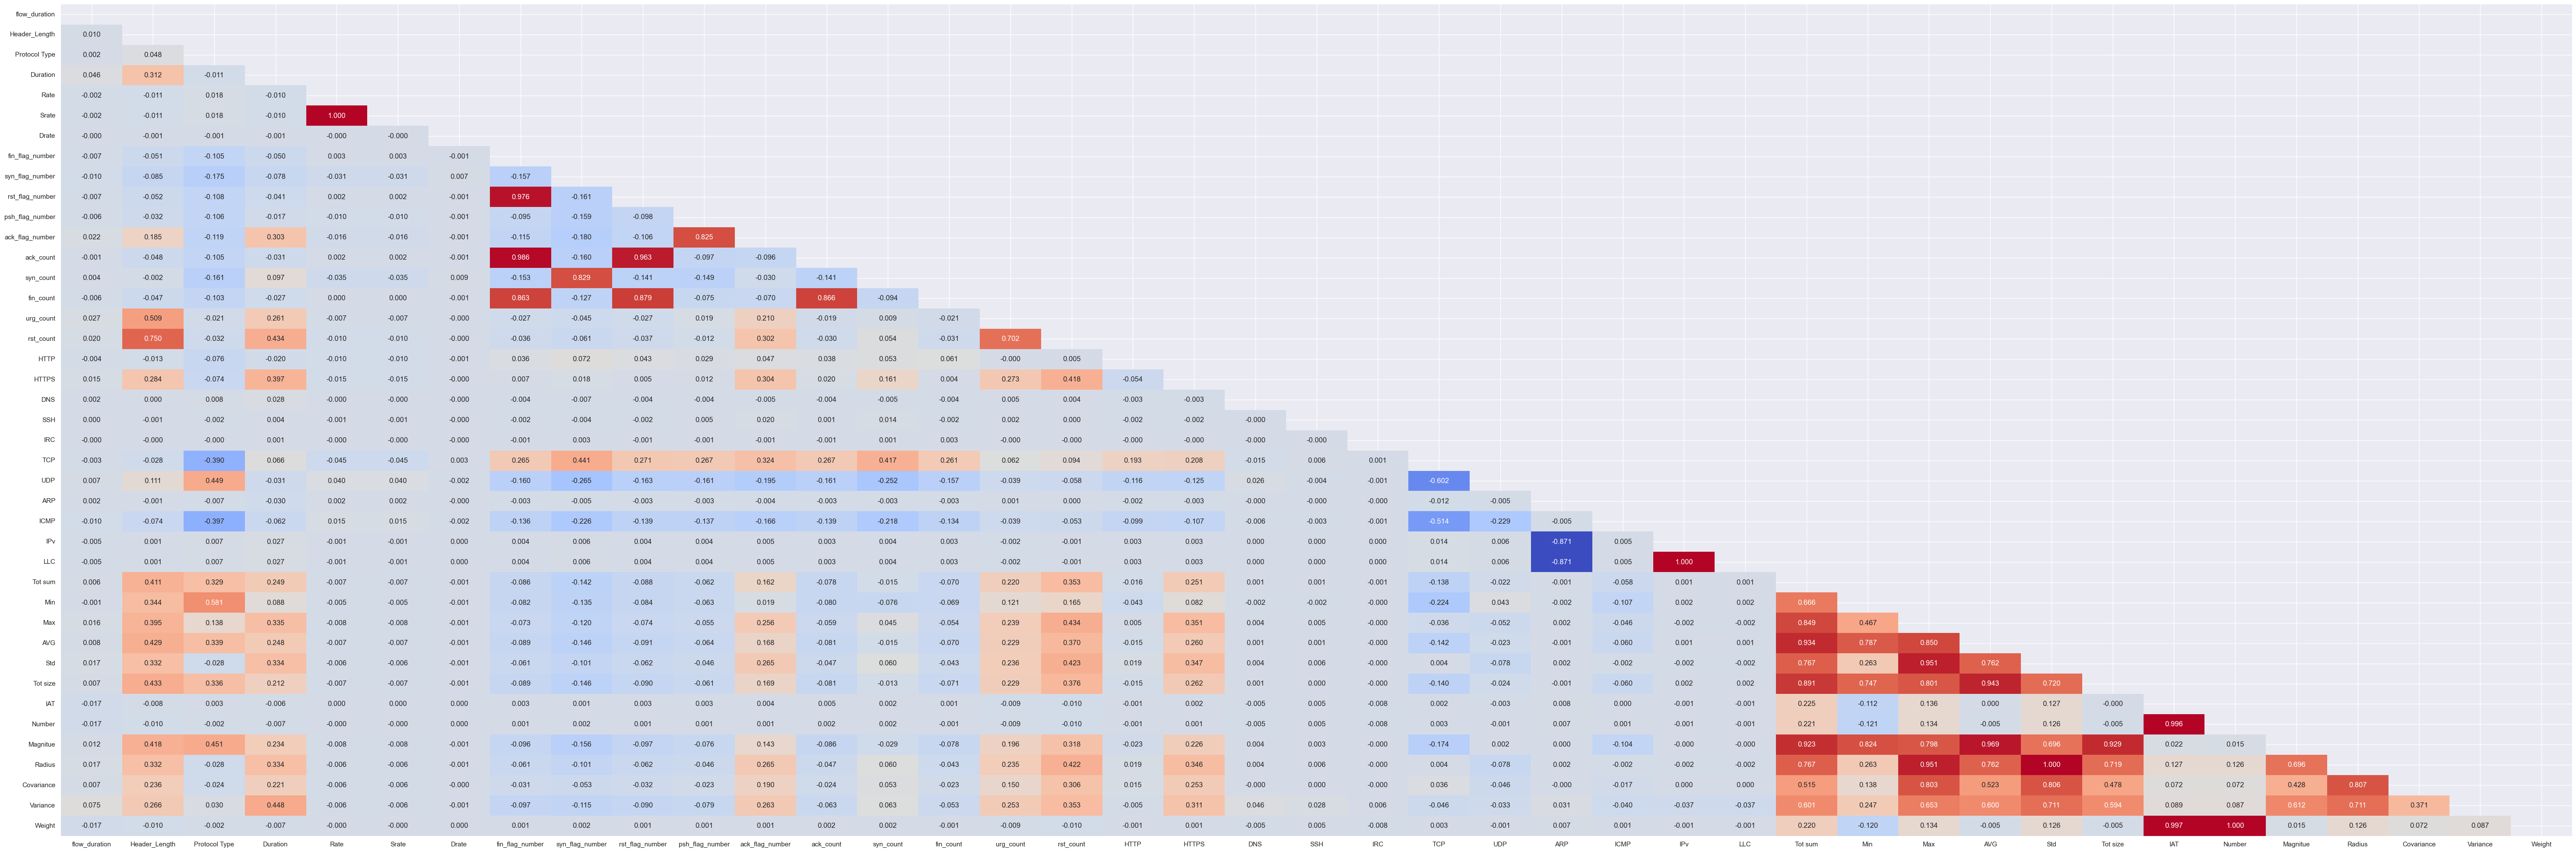

In [74]:
sns.set_theme(rc={"figure.figsize": (75, 25)})

corr = X_train_filtered.corr()
sns.heatmap(
    data=corr,
    cbar=False,
    cmap="coolwarm",
    fmt=".3f",
    mask=np.triu(corr),
    annot=True,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
)

In [75]:
if FEATURE_SELECTION:
    correlated_columns = correlation(X_train_filtered, 0.9)

    X_train = X_train_filtered.drop(correlated_columns)
    X_test = X_test_filtered.drop(correlated_columns)

### Balanceando o dataset

In [76]:
training_data.group_by("label").len()

label,len
str,u32
"""Recon""",2674
"""Spoofing""",3764
"""Benign""",8666
"""Mirai""",20940
"""DDoS""",271032
"""BruteForce""",142
"""DoS""",64499
"""Web""",815


In [77]:
sm = SMOTE(random_state=42)

pd_X_resampled, pd_y_resampled = sm.fit_resample(
    X_train.to_pandas(), y_train.to_pandas()
)
X_resampled, y_resampled = pl.from_pandas(pd_X_resampled), pl.from_pandas(
    pd_y_resampled
)

### Normalizando o dataset

In [78]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Testando os algoritmos

Aqui serão executados os algoritmos de classificação Logistic Regression, Perceptron, Adaboost e Random Forest, presentes no trabalho de Neto, E. C. P. *et al.*

In [79]:
data = ModelDataset(
    x_train=X_train_scaled,
    y_train=y_resampled.to_numpy(),
    x_test=X_test_scaled,
    y_test=y_test,
)

### Logistic Regression

In [80]:
logistic_regression_results = evaluate_model(
    model=LogisticRegression(n_jobs=-1, max_iter=10000), data=data
)
save_results(logistic_regression_results)

### Perceptron

In [81]:
perceptron_results = evaluate_model(model=Perceptron(), data=data)
save_results(perceptron_results)

### AdaBoost

In [82]:
adaboost_results = evaluate_model(model=AdaBoostClassifier(), data=data)
save_results(adaboost_results)

c:\Users\antonio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


KeyboardInterrupt: 

### Random Forest

In [ ]:
random_forest_results = evaluate_model(
    model=RandomForestClassifier(), data=data
)
save_results(random_forest_results)

# Análise dos Resultados

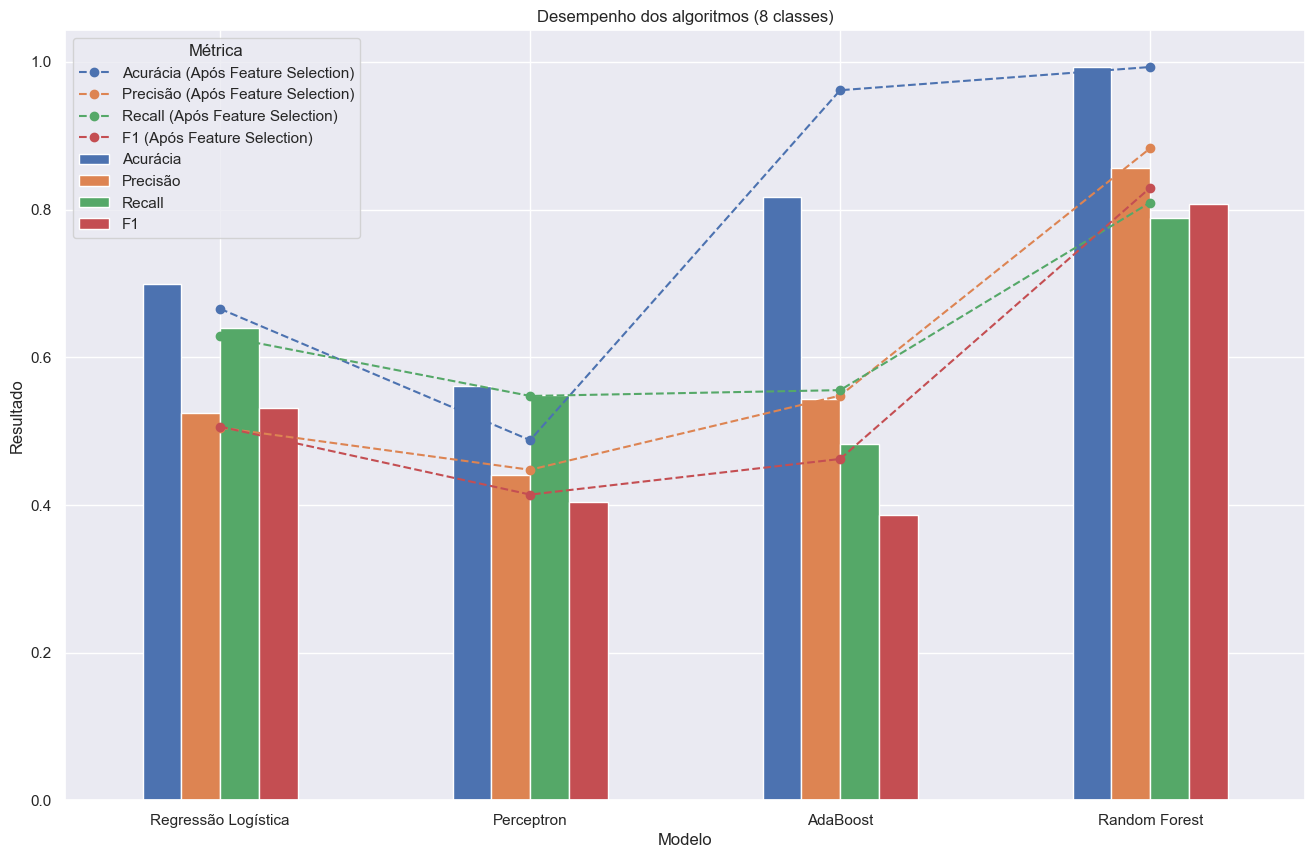

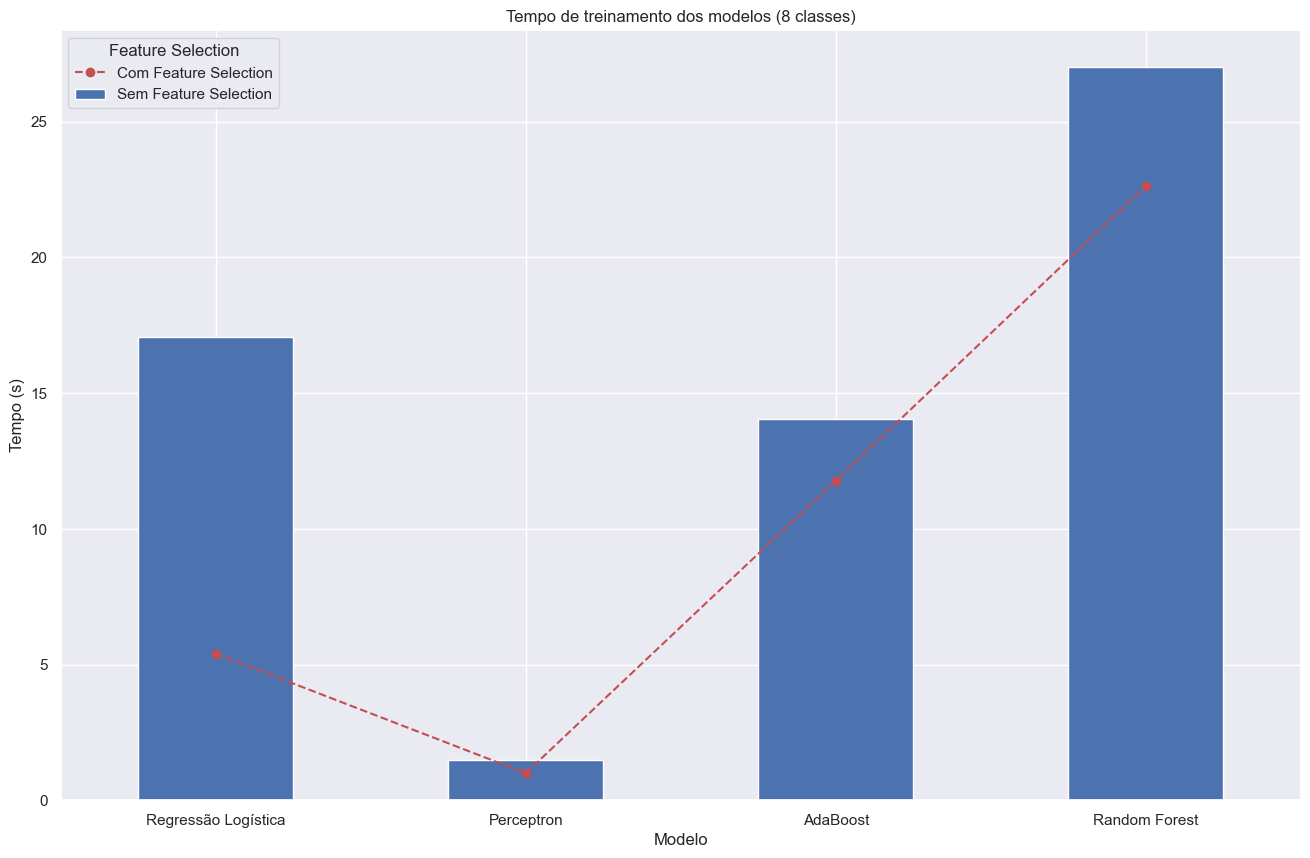

In [96]:
df = pd.read_csv(RESULTS_FILE)
df.drop_duplicates(inplace=True)
df["model"] = df["model"].replace(
    {
        "LogisticRegression": "Regressão Logística",
        "Perceptron": "Perceptron",
        "AdaBoostClassifier": "AdaBoost",
        "RandomForestClassifier": "Random Forest",
    }
)
df["duration_training"] = df["duration_training"] / 60
df = df.rename(
    columns={
        "accuracy_score": "Acurácia",
        "precision_score": "Precisão",
        "recall_score": "Recall",
        "f1_score": "F1",
        "duration_training": "Tempo de Treinamento",
    }
)
df.set_index("model", inplace=True)
grouped = df.groupby("num_features")

for num, df_group in grouped:
    df_false = df_group[~df_group["feature_selection"]]
    df_true = df_group[df_group["feature_selection"]]

    ax = df_false[["Acurácia", "Precisão", "Recall", "F1"]].plot(
        kind="bar", figsize=(16, 10), label="Sem Seleção de Recursos"
    )
    df_true[["Acurácia", "Precisão", "Recall", "F1"]].plot(
        kind="line",
        ax=ax,
        linestyle="--",
        marker="o",
        label="Com Seleção de Recursos",
    )

    plt.legend(
        labels=[
            "Acurácia (Após Feature Selection)",
            "Precisão (Após Feature Selection)",
            "Recall (Após Feature Selection)",
            "F1 (Após Feature Selection)",
            "Acurácia",
            "Precisão",
            "Recall",
            "F1",
        ],
        title="Métrica",
        loc="upper left",
    )
    plt.title(f"Desempenho dos algoritmos ({num} classes)")
    plt.xlabel("Modelo")
    plt.ylabel("Resultado")
    plt.show()

for num, df_group in grouped:
    df_false = df_group[~df_group["feature_selection"]]
    df_true = df_group[df_group["feature_selection"]]

    ax = df_false[["Tempo de Treinamento"]].plot(kind="bar", figsize=(16, 10))
    df_true[["Tempo de Treinamento"]].plot(
        kind="line", ax=ax, linestyle="--", marker="o", color="r"
    )

    plt.legend(
        title="Feature Selection",
        labels=["Com Feature Selection", "Sem Feature Selection"],
    )
    plt.title(f"Tempo de treinamento dos modelos ({num} classes)")
    plt.xlabel("Modelo")
    plt.ylabel("Tempo (min)")
    plt.show()